In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import numpy as np
import pickle
from matplotlib_venn import venn3, venn3_circles

In [ ]:
base_dir = "/content/drive/MyDrive/DeepProfiler/DeepProfiler-docs/Experimental_results/"
folder = "BBBC037"
fh_path = f"{base_dir}{folder}/First_hit/"
folder_names = ["CellProfiler","Pretrained","Combined_set"] 
strategies = ["CellProfiler", "ImageNet pretrained", "Trained on Cell Painting"]
sphering_params_epoch = ["1e-4", "1e-4", "1e-5_e30"] 
partitions = ["/", "/conv6a/", "/Cells_out/"]
file_names = ["cellprofiler", "efn128_pretrained_conv6a", "efn128_combinedcellsout_conv6a"] 
aggregation_level = "treatment_level"

In [ ]:
main_colors = ["tab:pink","tab:olive","tab:cyan"] 
high_colors = ["deeppink", "gold", "deepskyblue"]

# First hit results

In [ ]:
first_hits = []
for k in range(len(strategies)):
  df = pd.read_csv(f"{fh_path}{folder_names[k]}{partitions[k]}{file_names[k]}_{sphering_params_epoch[k]}_{aggregation_level}.csv", index_col=0)
  df["Strategy"] = strategies[k]
  first_hits.append(df)
first_hits = pd.concat(first_hits).reset_index()

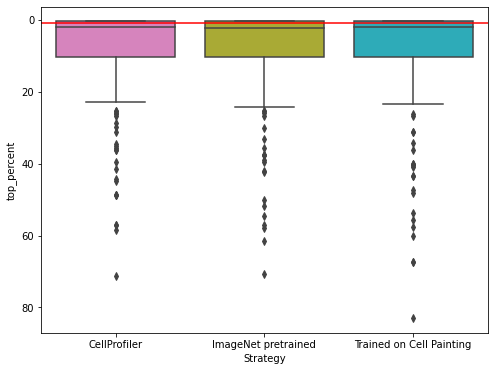

In [ ]:
plt.figure(figsize=(8,6))
g = sb.boxplot(data=first_hits, x="Strategy", y="top_percent", palette=main_colors)
g.invert_yaxis()
plt.axhline(y=1, color='r', linestyle='-')

[(0.0, 5.0)]

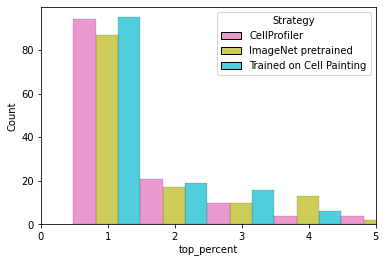

In [ ]:
g = sb.histplot(first_hits, x="top_percent", hue="Strategy", binwidth=1, multiple="dodge", palette=main_colors)
g.set(xlim=(0, 5))

[(1.0, 10.0)]

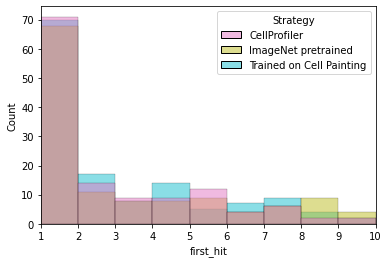

In [ ]:
g = sb.histplot(first_hits, x="first_hit", hue="Strategy", binwidth=1, multiple="layer", palette=main_colors)
g.set(xlim=(1, 10))

,Strategy,index,broad_sample,pert_name,first_hit,top_percent
0,CellProfiler,85,85,85,85,85
1,ImageNet pretrained,79,79,79,79,79
2,Trained on Cell Painting,87,87,87,87,87


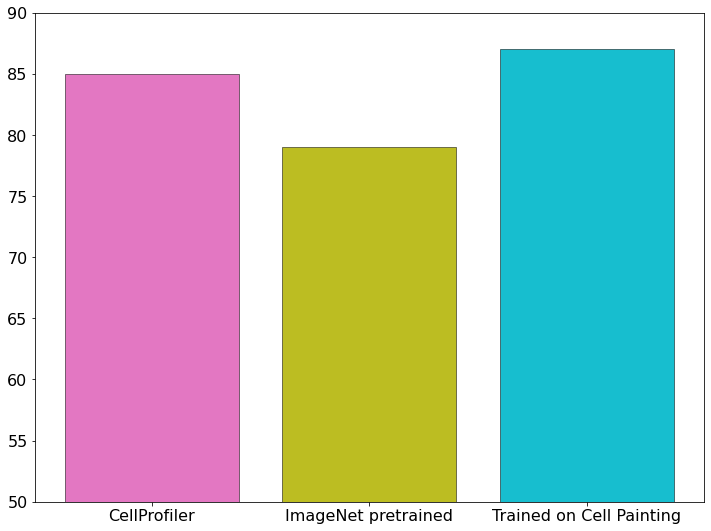

In [ ]:
counts = first_hits[first_hits.top_percent <= 1].groupby("Strategy").count().reset_index()
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(12,9))
b = plt.bar(counts.Strategy, counts.broad_sample)
t = ax.set_ylim([50, 90])
for k in range(3): 
  b[k].set_color(main_colors[k])
  b[k].set_linewidth(0.5)
  b[k].set_edgecolor('black')
counts

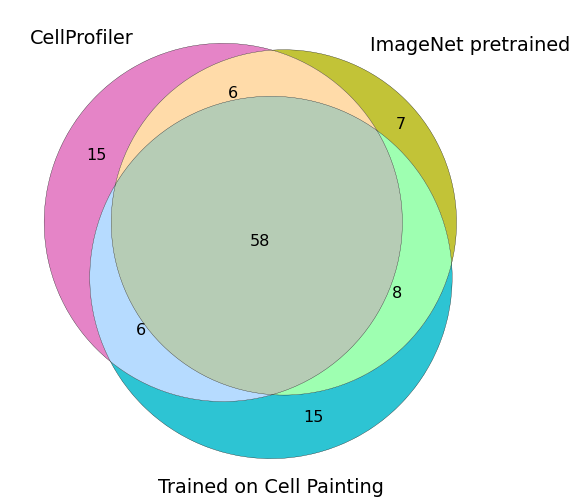

In [ ]:
sets = []
for k in range(len(strategies)):
  s = set(first_hits.query(f"top_percent <= 1. & Strategy == '{strategies[k]}'").pert_name)
  sets.append(s)
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(12,9))
venn3(sets, strategies, set_colors=main_colors, alpha=0.9)
venn3_circles(sets, linewidth=0.3)

# Ranking performance and enrichment analysis

In [ ]:
folder = "BBBC037"
map_path = f"{base_dir}{folder}/mAP_FoE/"
file_names = ["cellprofiler", "efn128_pretrained_conv6a", "efn128_combinedcellsout_conv6a"]

In [ ]:
map_foe = []
for k in range(len(strategies)):
  print(strategies[k])
  df = pd.read_csv(f"{map_path}{folder_names[k]}{partitions[k]}{file_names[k]}_{sphering_params_epoch[k]}.csv", index_col=0)
  df["Strategy"] = strategies[k]
  map_foe.append(df)
map_foe = pd.concat(map_foe).reset_index()

CellProfiler


FileNotFoundError: ignored

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 36.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 40.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 36.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


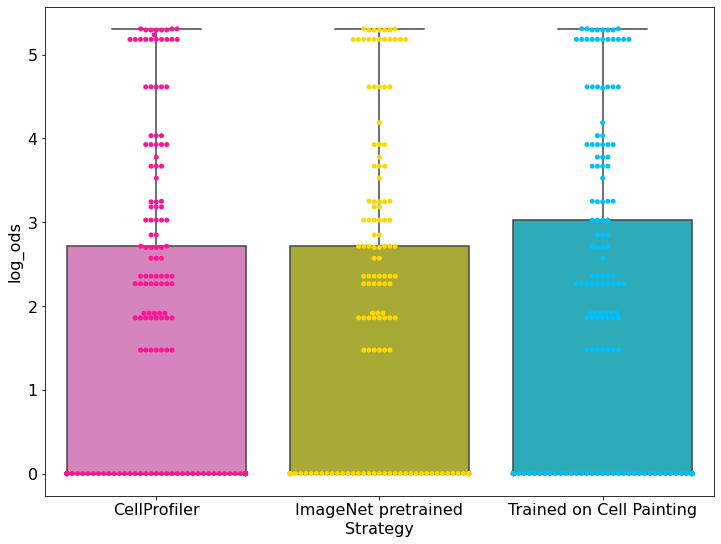

In [ ]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(12,9))
map_foe["log_ods"] = np.log(map_foe["ods_ratio"]+1)
g = sb.swarmplot(data=map_foe, x="Strategy", y="log_ods", palette=high_colors)
g = sb.boxplot(data=map_foe, x="Strategy", y="log_ods", palette=main_colors)

In [ ]:
map_foe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           612 non-null    int64  
 1   Var1            612 non-null    object 
 2   percentile      612 non-null    float64
 3   threshold       612 non-null    float64
 4   ods_ratio       612 non-null    float64
 5   p-value         612 non-null    float64
 6   V               612 non-null    object 
 7   precision_at_k  612 non-null    float64
 8   pk              612 non-null    float64
 9   recall_at_k     612 non-null    float64
 10  rk              612 non-null    float64
 11  Strategy        612 non-null    object 
 12  log_ods         612 non-null    float64
dtypes: float64(9), int64(1), object(3)
memory usage: 62.3+ KB


In [ ]:
import statsmodels.stats.multitest as multi
for s in strategies:
  r,cpv,_,_ = multi.multipletests(map_foe.loc[map_foe.Strategy==s, "p-value"])
  print(s,np.sum(r))

CellProfiler 6
ImageNet pretrained 5
Trained on Cell Painting 6


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
all_results = pd.merge(first_hits, map_foe, left_on=["broad_sample","Strategy"], right_on=["Var1", "Strategy"]).reset_index()

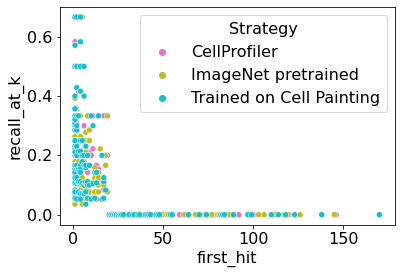

In [ ]:
sb.scatterplot(data=all_results, x="first_hit", y="recall_at_k", hue="Strategy", palette=main_colors)

In [ ]:
trt_index = pd.read_csv(f"{base_dir}{folder}/TAORF_MOA_MATCHES_official.csv")

In [ ]:
df = pd.DataFrame([{"Strategy":"CellProfiler","Enrichment":25.8857961834637,"mAP":0.171595278161499, "First-Hit":85},
                   #{"Strategy":"ImageNet Pretrained","Enrichment":24.807582328283,"mAP":0.163387833879206, "First-Hit":80},
                   #{"Strategy":"ImageNet Pretrained","Enrichment":24.0154868114632,"mAP":0.164138546157203, "First-Hit":79},
                   {"Strategy":"ImageNet Pretrained","Enrichment":23.2168593604828,"mAP":0.164134703023874, "First-Hit":0},
                   #{"Strategy":"WSL - Combined Set Plates Out","Enrichment":24.7058328012577,"mAP":0.1812314217, "First-Hit":90},
                   {"Strategy":"WSL - Combined Set Cells Out","Enrichment":27.3315446577643,"mAP":0.183819584358233, "First-Hit":87},
                   #{"Strategy":"WSL - Individual Set Plates Out","Enrichment":25.5382425902624,"mAP":0.179731414574113, "First-Hit":85},
                   {"Strategy":"WSL - Individual Set Cells Out","Enrichment":24.9248702496561,"mAP":0.180329551455622, "First-Hit":87}])
df

,Strategy,Enrichment,mAP,First-Hit
0,CellProfiler,25.885796,0.171595,85
1,ImageNet Pretrained,23.216859,0.164135,0
2,WSL - Combined Set Cells Out,27.331545,0.183820,87
3,WSL - Individual Set Cells Out,24.924870,0.180330,87


In [ ]:
#main_colors = ["tab:pink","tab:olive","tab:cyan", "tab:cyan", "tab:green", "tab:green"]
#main_markers = ['o', 'o', 'D', 'o', 'D', 'o']
main_colors = ["tab:pink","tab:olive","tab:cyan", "tab:green"]
main_markers = ['o', 'o', 'o', 'o']

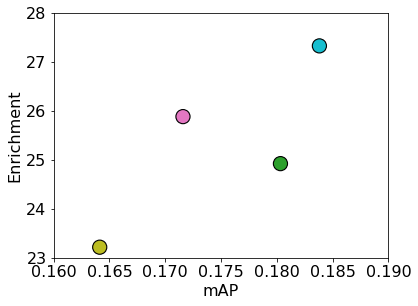

In [ ]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(6,4.5))
sb.scatterplot(data=df, x="mAP", y="Enrichment", hue="Strategy", s=200, edgecolor="black", palette=main_colors, style = 'Strategy', markers = main_markers)
t = ax.set_xlim([0.16, 0.19])
t = ax.set_ylim([23, 28])
plt.legend(loc='upper left')
ax.get_legend().remove()


In [ ]:
df = pd.DataFrame([{"Strategy":"CellProfiler","Enrichment":25.8857961834637,"mAP":0.171595278161499, "First-Hit":85},
                   #{"Strategy":"ImageNet Pretrained","Enrichment":24.0154868114632,"mAP":0.164138546157203, "First-Hit":79},
                   {"Strategy":"ImageNet Pretrained","Enrichment":23.2168593604828,"mAP":0.164134703023874, "First-Hit":0},
                   {"Strategy":"WSL - Combined Set Cells Out","Enrichment":27.3315446577643,"mAP":0.183819584358233, "First-Hit":87},
                   {"Strategy":"WSL - Individual Set Cells Out","Enrichment":24.9248702496561,"mAP":0.180329551455622, "First-Hit":87},
                   {"Strategy":"WSL - Combined Set Cells Out Masked","Enrichment":24.4626333618083,"mAP":0.179425342787277, "First-Hit":0}
                   ])
df

In [ ]:
main_colors = ["tab:pink","tab:olive","tab:cyan", "tab:green", "tab:gray"]
main_markers = ['o', 'o', 'o', 'o', 'o']

In [ ]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(8,6))
sb.scatterplot(data=df, x="mAP", y="Enrichment", hue="Strategy", s=200, edgecolor="black", palette=main_colors, style = 'Strategy', markers = main_markers)
t = ax.set_xlim([0.16, 0.19])
t = ax.set_ylim([23, 28])
plt.legend(loc='upper left')
ax.get_legend().remove()


In [ ]:
df = pd.DataFrame([{"Strategy":"CellProfiler","Enrichment":25.8857961834637,"mAP":0.171595278161499, "First-Hit":85},
                   #{"Strategy":"ImageNet Pretrained","Enrichment":23.2168593604828,"mAP":0.164134703023874, "First-Hit":0},
                   #{"Strategy":"WSL - Combined Set Plates Out","Enrichment":24.7058328012577,"mAP":0.1812314217, "First-Hit":90},
                   #{"Strategy":"WSL - Combined Set Cells Out","Enrichment":27.3315446577643,"mAP":0.183819584358233, "First-Hit":87},
                   #{"Strategy":"WSL - Individual Set Plates Out","Enrichment":25.5382425902624,"mAP":0.179731414574113, "First-Hit":85},
                   {"Strategy":"WSL - Individual Set Cells Out","Enrichment":24.9248702496561,"mAP":0.180329551455622, "First-Hit":87},
                   #{"Strategy":"WSL - Individual Strong Set Plates Out","Enrichment":26.2029116924261,"mAP":0.17743978632875, "First-Hit":0},
                   {"Strategy":"WSL - Individual Strong Set Cells Out","Enrichment":27.5324750691446,"mAP":0.1847384157794, "First-Hit":0},
                   #{"Strategy":"WSL - Individual Median Set Plates Out","Enrichment":26.884567951152,"mAP":0.180899258574008, "First-Hit":0},
                   {"Strategy":"WSL - Individual Median Set Cells Out","Enrichment":25.2738689319139,"mAP":0.175826526030758, "First-Hit":0},
                   #{"Strategy":"WSL - Individual Weak Set Plates Out","Enrichment":24.3213523531927,"mAP":0.164525234511162, "First-Hit":0},
                   {"Strategy":"WSL - Individual Weak Set Cells Out","Enrichment":25.0238396229875,"mAP":0.170741185500821, "First-Hit":0}
                   ])
df

,Strategy,Enrichment,mAP,First-Hit
0,CellProfiler,25.885796,0.171595,85
1,WSL - Individual Set Cells Out,24.924870,0.180330,87
2,WSL - Individual Strong Set Cells Out,27.532475,0.184738,0
3,WSL - Individual Median Set Cells Out,25.273869,0.175827,0
4,WSL - Individual Weak Set Cells Out,25.023840,0.170741,0


In [ ]:
#main_colors = ["tab:pink","tab:olive","tab:cyan", "tab:cyan", "tab:green", "tab:green", "tab:red", "tab:red", "tab:orange", "tab:orange", "tab:blue", "tab:blue"]
#main_markers = ['o', 'o', 'D', 'o', 'D', 'o', 'D', 'o', 'D', 'o', 'D', 'o']
#main_colors = ["tab:pink","tab:olive","tab:cyan", "tab:green", "tab:red",  "tab:orange", "tab:blue"]
#main_markers = ['o', 'o', 'o', 'o', 'o', 'o', 'o']
main_colors = ["tab:pink","tab:green", "tab:red",  "tab:orange", "tab:blue"]
main_markers = ['o', 'o', 'o', 'o', 'o']

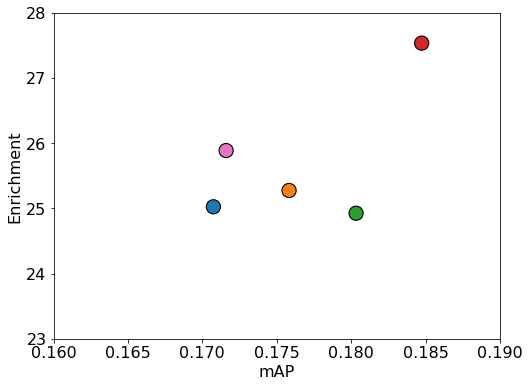

In [ ]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(8,6))
sb.scatterplot(data=df, x="mAP", y="Enrichment", hue="Strategy", s=200, edgecolor="black", palette=main_colors, style = 'Strategy', markers = main_markers)
t = ax.set_xlim([0.16, 0.19])
t = ax.set_ylim([23, 28])
plt.legend(loc='upper left')
ax.get_legend().remove()

In [ ]:
full_results = pd.merge(all_results, trt_index, left_on=["broad_sample", "pert_name"], right_on=["broad_sample", "pert_name"])
full_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 612 entries, 0 to 611
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    612 non-null    int64  
 1   index_x                  612 non-null    int64  
 2   broad_sample             612 non-null    object 
 3   pert_name                612 non-null    object 
 4   first_hit                612 non-null    int64  
 5   top_percent              612 non-null    float64
 6   Strategy                 612 non-null    object 
 7   index_y                  612 non-null    int64  
 8   Var1                     612 non-null    object 
 9   percentile               612 non-null    float64
 10  threshold                612 non-null    float64
 11  ods_ratio                612 non-null    float64
 12  p-value                  612 non-null    float64
 13  V                        612 non-null    object 
 14  precision_at_k           6

In [ ]:
stats = full_results.groupby(["Metadata_moa", "Strategy"])[["first_hit", "top_percent","ods_ratio","precision_at_k"]].mean().reset_index()
counts = full_results.groupby(["Metadata_moa", "Strategy"])["first_hit"].count().reset_index()
stats = pd.merge(stats, counts.rename({"first_hit":"counts"}, axis=1), on=["Metadata_moa","Strategy"])

In [ ]:
main_colors = ["tab:pink","tab:olive","tab:cyan"] 
high_colors = ["deeppink", "gold", "deepskyblue"]

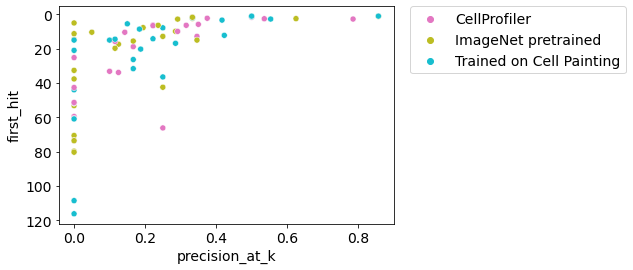

In [ ]:
g = sb.scatterplot(data=stats[stats.counts >= 3], x="precision_at_k", y="first_hit", hue="Strategy", palette=main_colors)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.invert_yaxis()

<BarContainer object of 27 artists>

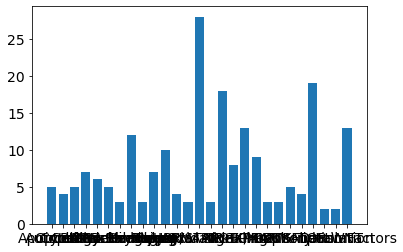

In [ ]:
plt.bar(stats[stats.Strategy == "CellProfiler"].Metadata_moa, stats[stats.Strategy == "CellProfiler"].counts)

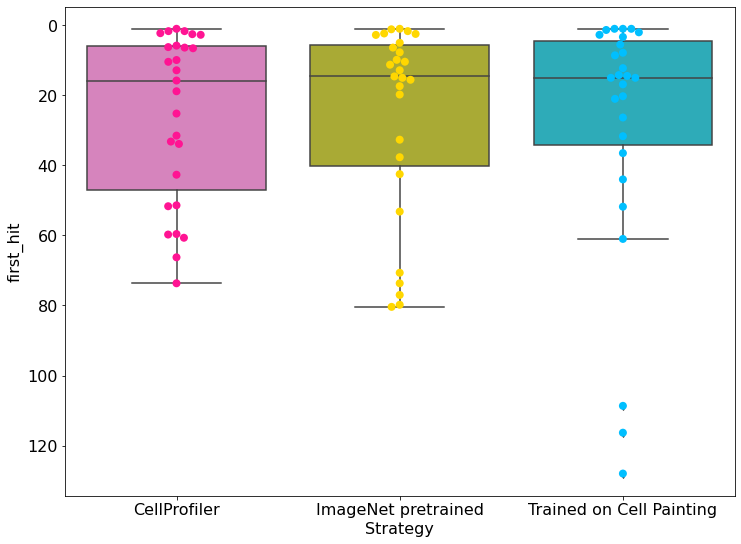

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(12,9))
g = sb.swarmplot(data=stats[stats.counts >= 2], x="Strategy", y="first_hit", size=8, palette=high_colors)
g = sb.boxplot(data=stats[stats.counts >= 2], x="Strategy", y="first_hit", palette=main_colors)
g.invert_yaxis()

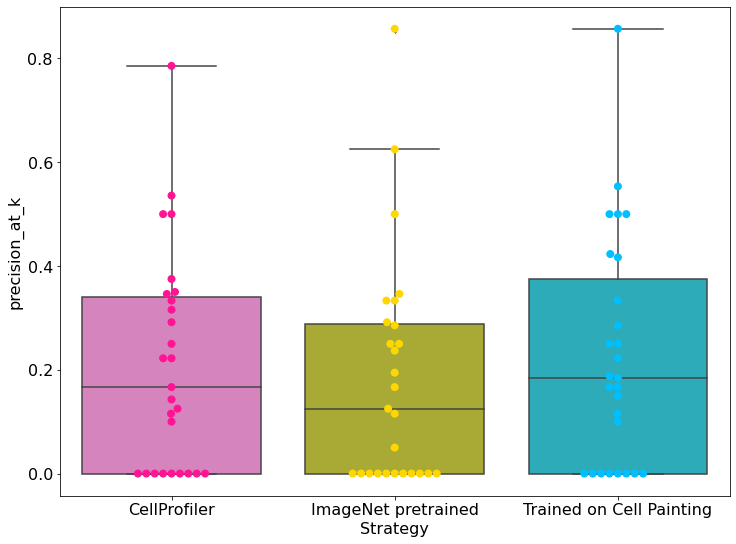

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(12,9))
g = sb.swarmplot(data=stats[stats.counts >= 2], x="Strategy", y="precision_at_k", size=8, palette=high_colors)
g = sb.boxplot(data=stats[stats.counts >= 2], x="Strategy", y="precision_at_k", palette=main_colors)

In [ ]:
stats

,Metadata_moa,Strategy,first_hit,top_percent,ods_ratio,precision_at_k,counts
0,Apoptosis,CellProfiler,25.200000,12.292683,0.000000,0.000000,5
1,Apoptosis,ImageNet pretrained,53.200000,25.951220,0.000000,0.000000,5
2,Apoptosis,Trained on Cell Painting,44.000000,21.463415,0.000000,0.000000,5
3,Autophagy,CellProfiler,59.750000,29.146341,0.000000,0.000000,4
4,Autophagy,ImageNet pretrained,11.250000,5.487805,0.000000,0.000000,4
...,...,...,...,...,...,...,...
76,Translation,ImageNet pretrained,77.000000,37.560976,0.000000,0.000000,2
77,Translation,Trained on Cell Painting,128.000000,62.439024,0.000000,0.000000,2
78,WNT,CellProfiler,15.769231,7.692308,1.993007,0.115385,13
79,WNT,ImageNet pretrained,19.769231,9.643527,1.993007,0.115385,13


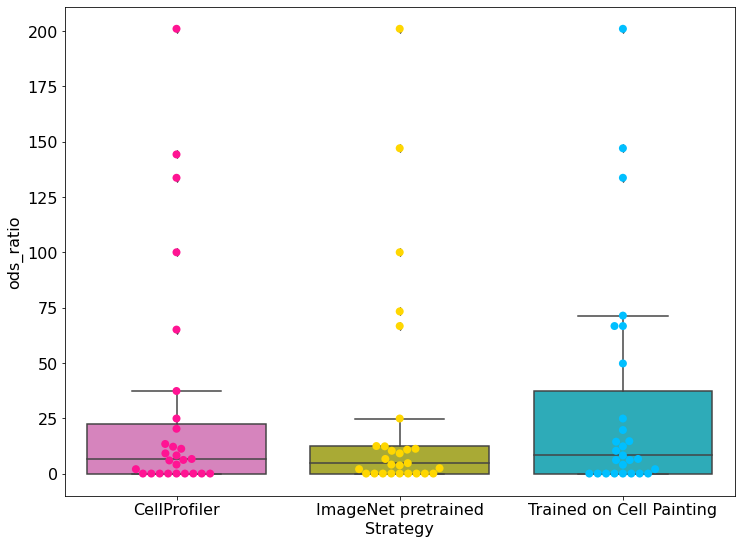

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(12,9))
g = sb.swarmplot(data=stats[stats.counts >= 2], x="Strategy", y="ods_ratio", size=8, palette=high_colors)
g = sb.boxplot(data=stats[stats.counts >= 2], x="Strategy", y="ods_ratio", palette=main_colors)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.0, 0.5)

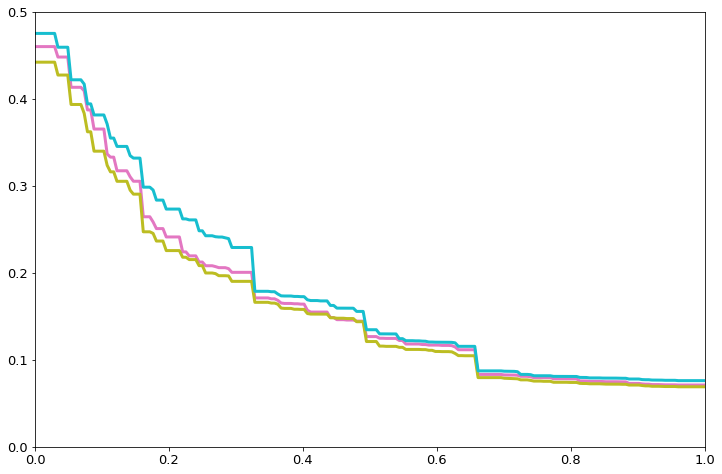

In [ ]:
with open(f"{map_path}{folder_names[0]}{partitions[0]}{file_names[0]}_{sphering_params_epoch[0]}.pkl", "rb") as in_file:
    cp_results = pickle.load(in_file) 

with open(f"{map_path}{folder_names[1]}{partitions[1]}{file_names[1]}_{sphering_params_epoch[1]}.pkl", "rb") as in_file:
    en_results = pickle.load(in_file) 

with open(f"{map_path}{folder_names[2]}{partitions[2]}{file_names[2]}_{sphering_params_epoch[2]}.pkl", "rb") as in_file:
    en2_results = pickle.load(in_file)

plt.figure(figsize=(12,8))
sb.lineplot(cp_results["recall_axis"], cp_results["precision_axis"], color=main_colors[0], linewidth = 3)
sb.lineplot(en_results["recall_axis"], en_results["precision_axis"], color=main_colors[1], linewidth = 3)
g = sb.lineplot(en2_results["recall_axis"], en2_results["precision_axis"], color=main_colors[2], linewidth = 3)
#plt.gca().legend(('CellProfiler', 'ImageNet pretrained', 'Trained on Cell Painting'),fontsize=16)
g.set_xlim(0,1.)
g.set_ylim(0,0.5)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

(0.9, 5.1)

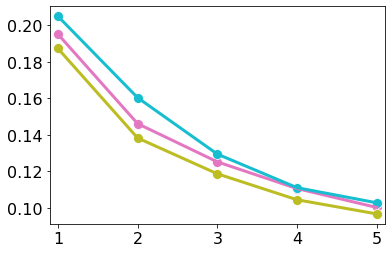

In [ ]:
start, stop = 0,5
sb.lineplot(range(start+1,stop+1), cp_results["precision_at_k"][start:stop], color=main_colors[0], linewidth = 3)
sb.scatterplot(range(start+1,stop+1), cp_results["precision_at_k"][start:stop], color=main_colors[0], s=100)

sb.lineplot(range(start+1,stop+1), en_results["precision_at_k"][start:stop], color=main_colors[1], linewidth = 3)
sb.scatterplot(range(start+1,stop+1), en_results["precision_at_k"][start:stop], color=main_colors[1], s=100)

g = sb.lineplot(range(start+1,stop+1), en2_results["precision_at_k"][start:stop], color=main_colors[2], linewidth = 3)
g = sb.scatterplot(range(start+1,stop+1), en2_results["precision_at_k"][start:stop], color=main_colors[2], s=100)
g.set_xlim(0.9,stop+0.1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.085, 0.2)

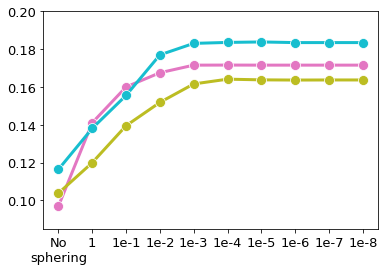

In [ ]:
sphering_params_comparison = ['no', '1', '1e-1', '1e-2', '1e-3', '1e-4', '1e-5', '1e-6', '1e-7', '1e-8']
sphering_params_comparison_axis = ['No' + "\n" + 'sphering', '1', '1e-1', '1e-2', '1e-3', '1e-4', '1e-5', '1e-6', '1e-7', '1e-8']

cellprofiler_map = []
imagenet_map = []
combinedset_map = []

for sp in range(len(sphering_params_comparison)):
  with open(f"{map_path}{folder_names[0]}{partitions[0]}{file_names[0]}_{sphering_params_comparison[sp]}.pkl", "rb") as in_file:
    cp_results = pickle.load(in_file)
    cellprofiler_map.append(cp_results['mean_average_precision'])

  with open(f"{map_path}{folder_names[1]}{partitions[1]}{file_names[1]}_{sphering_params_comparison[sp]}.pkl", "rb") as in_file:
     en_results = pickle.load(in_file)
     imagenet_map.append(en_results['mean_average_precision'])

  with open(f"{map_path}{folder_names[2]}{partitions[2]}{file_names[2]}_{sphering_params_comparison[sp]}_e30.pkl", "rb") as in_file:
      en2_results = pickle.load(in_file)
      combinedset_map.append(en2_results['mean_average_precision'])
      

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 13})
sb.lineplot(sphering_params_comparison_axis, cellprofiler_map, color=main_colors[0], linewidth = 3, marker='o', markersize=10)
sb.lineplot(sphering_params_comparison_axis, imagenet_map, color=main_colors[1], linewidth = 3, marker='o', markersize=10)
g = sb.lineplot(sphering_params_comparison_axis, combinedset_map, color=main_colors[2], linewidth = 3, marker='o', markersize=10)
g.set_ylim(0.085, 0.2)
#plt.gca().legend(('CellProfiler', 'ImageNet pretrained', 'Trained on Cell Painting'),fontsize=16)

In [ ]:
df = pd.DataFrame([{"Strategy":"CellProfiler","Enrichment":25.8857961834637,"mAP":0.171595278161499, "First-Hit":85},
                   {"Strategy":"ImageNet Pretrained","Enrichment":24.0154868114632,"mAP":0.164138546157203, "First-Hit":79},
                   {"Strategy":"WSL - Combined Set Plates Out","Enrichment":24.7058328012577,"mAP":0.1812314217, "First-Hit":90},
                   {"Strategy":"WSL - Individual Set Plates Out","Enrichment":25.5382425902624,"mAP":0.179731414574113, "First-Hit":85},
                   {"Strategy":"WSL - Strong Treatments Plates Out","Enrichment":25.7346442268803,"mAP":0.181425121251807, "First-Hit":84}])
df

,Strategy,Enrichment,mAP,First-Hit
0,CellProfiler,25.885796,0.171595,85
1,ImageNet Pretrained,24.015487,0.164139,79
2,WSL - Combined Set Plates Out,24.705833,0.181231,90
3,WSL - Individual Set Plates Out,25.538243,0.179731,85
4,WSL - Strong Treatments Plates Out,25.734644,0.181425,84


In [ ]:
main_colors = ["tab:pink","tab:olive","tab:cyan", "tab:green", "tab:blue"]
main_markers = ['o', 'o', 'D', 'D', 'D']

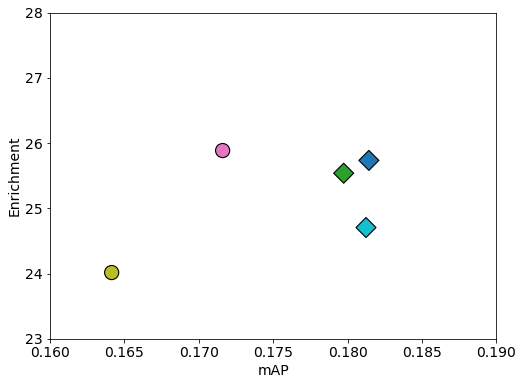

In [ ]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(8,6))
sb.scatterplot(data=df, x="mAP", y="Enrichment", hue="Strategy", s=200, edgecolor="black", palette=main_colors, style = 'Strategy', markers = main_markers)
t = ax.set_xlim([0.16, 0.19])
t = ax.set_ylim([23, 28])
plt.legend(loc='upper left')
ax.get_legend().remove()